**By: Alex Marzban**

**Visit the GitHub repository to access the code for this assignment:** [https://github.com/marzbana/CS521_HWs/tree/main/hw3](https://github.com/marzbana/CS521_HWs/tree/main/hw3)

There is a jupyter notebook to view.


In [ ]:
from google.colab import userdata
github_path = "https://" + userdata.get('GitHubUserName') + ":" + userdata.get('GitHubPAT') + "@github.com/marzbana/CS521_HWs.git"
! git clone {github_path}
%cd CS521_HWs/hw3
! pip install -r requirements.txt


In [ ]:
%cd /content/CS521_HWs/hw3

! git add BoW.pth
! git add BoW_standard.pth
#! git add requirements.txt
#! git reset HEAD~
! git status
#! git config --global user.email "marza@bu.edu"
#! git commit -m "hw3 collab"
#! git push


In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torchtext.datasets import IMDB
from torchtext.vocab import GloVe
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab, build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
import portalocker
import random
from sklearn.neighbors import NearestNeighbors
import math

from torchvision import datasets, transforms

current_dir = os.path.dirname(os.path.abspath('__file__'))

# code_dir = os.path.join(current_dir, 'code')

# if code_dir not in sys.path:
#     sys.path.append(code_dir)


## Problem 1: Interval Bound Propagation (IBP) Training

In this problem, you will implement interval bound propagation (IBP) training for a simple neural network.

### Network Description

Implement a fully connected neural network consisting of 3 layers (each *layer* here is a linear layer followed by a ReLU), each of size 50 neurons. Use cross-entropy loss and train on the MNIST dataset. You can use the dataloaders from previous assignments ([GitHub Link](https://github.com/ishcha/CS521_HWs/blob/main/hw1/adversarial_training.ipynb)).

### 1. IBP Training Procedure

Implement the IBP [GDS+19] training procedure on your network. Use the training tricks used by the paper — gradual reduction of the weighing factor $k$ in Equation 12 of the paper from 1 to 0.5 (see hints below) and gradual increase in the robustness radius $\epsilon_{\text{train}}$ as the training progresses, starting from 0 to target $\epsilon_{\text{train}} = 0.1$. Report the standard accuracy and robust accuracy (with respect to PGD attack) of your network. Also report the training time and contrast it with that of standard training.

### 2. Box Verification

Use your box verification implementation from HW-2 and report the verified accuracy (number of test images for which the network is certified robust in an $L_{\infty}$ radius of $\epsilon_{\text{test}}$ ball), where $\epsilon_{\text{test}}$ can take 10 values, evenly between 0.01 and 0.1. Analyze images of some adversarial examples with perturbations within different $\epsilon_{\text{test}}$ if your network is not certified to be robust for some $\epsilon_{\text{test}}$.

### Solution Requirements

You should present your solution for this in the form of a Jupyter notebook. We recommend using Google Colab since we can interact with your solution easily, but you can also just upload the notebook to your GitHub repo.

### Hints

IBP procedure modifies the training loss function by having another robustness loss term. The overall loss looks as follows, where $\text{CE}(\cdot, \cdot)$ is the cross-entropy loss and $z_K$ are the logits at the last layer $K$:

$$
\mathcal{L}_{\text{IBP}} = k \cdot \text{CE}(z_K, y_{\text{true}}) + (1 - k) \cdot \text{CE}(\hat{z}_K(\epsilon_{\text{train}}), y_{\text{true}})
$$

The last linear layer is typically absorbed in the robustness specification, as demonstrated in Equation 9 of the paper. You need to basically redefine the loss function in your training process, including the training tricks in the paper for your IBP training.


In [ ]:
#create model and load data
print("Training LLM with 3 layers")
# from tensorboardX import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100

np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor()
])

## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#neural network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        ])

    def forward(self, x):
        x = x.view((-1, 28*28))
        for layer in self.layers:
            x = layer(x)
        return x

model = Net().to(device)
model.train()



In [104]:
def IBP(model, x, eps):
    z_lower = x - eps
    z_upper = x + eps

    z_lower = torch.clamp(z_lower, 0, 1)
    z_upper = torch.clamp(z_upper, 0, 1)
    for layer in model.layers:
       if isinstance(layer, nn.Linear):
        W = layer.weight
        b = layer.bias
        W_abs = W.abs()

        uk_1 = (z_lower + z_upper)/2
        rk_1 = (z_upper - z_lower)/2
        uk = F.linear(uk_1, W, b)
        rk = F.linear(rk_1, W_abs, None)

        z_lower = uk - rk
        z_upper = uk + rk
       elif isinstance(layer, nn.ReLU):
        z_lower = F.relu(z_lower)
        z_upper = F.relu(z_upper)
       else:
          raise NotImplementedError(f"Layer {layer} not supported in IBP.")
    return z_lower, z_upper

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,logits, labels, worst_case_logits, k):
        L_fit = F.cross_entropy(logits,labels)
        if k == 1: return L_fit
        L_spec = F.cross_entropy(worst_case_logits, labels)

        loss = k * L_fit + (1-k) * L_spec
        return loss

def getEps(current_step, total_steps, eps_final):
    stopping = 10000*total_steps/60000
    if current_step < stopping: return (current_step / stopping) * (eps_final)
    else: return eps_final

def getK(current_step, total_steps, k_final):
    stopping = 2000*total_steps/60000
    if current_step < stopping: return 1 - ((current_step / stopping) * (1-k_final))
    else: return k_final

def zEPS(z_lower, z_upper, y_target):
    z_eps = z_upper.clone()

    z_eps[torch.arange(len(y_target)), y_target] = z_lower[torch.arange(len(y_target)), y_target]

    return z_eps

def train(model, epochs, eps_final, k_final, train_loader):
    model.train()
    total_steps = epochs * len(train_loader)
    def customSchedule(current_step):
        checkpoint1 = int(15000 * total_steps / 60000)
        checkpoint2 = int(25000 * total_steps / 60000)

        if current_step >= checkpoint1 and current_step < checkpoint2:
            return 0.1
        elif current_step >= checkpoint2:
            return 0.01
        else:
            return 1.0
    current_step = 0
    criterion = CustomLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = LambdaLR(optimizer, lr_lambda=customSchedule)
    for epoch in range(1, epochs + 1):
       total_loss = 0.0
       correct = 0
       total = 0

       for _, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()

          logits = model(data)
          eps = getEps(current_step, total_steps, eps_final)
          data = data.view(-1, 28*28)
          z_lower, z_upper = IBP(model, data, eps)
          z_eps = zEPS(z_lower, z_upper, target)
          k = getK(current_step, total_steps, k_final)
          loss = criterion(logits, target, z_eps, k)

          loss.backward()
          optimizer.step()
          scheduler.step()


          total_loss += loss.item()
          _, predicted = torch.max(logits, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()
          current_step += 1

       epoch_loss = total_loss / len(train_loader.dataset)
       epoch_accuracy = 100.0 * correct / total


       if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.9f} - Accuracy: {epoch_accuracy:.2f}%")




## IBP Training Implementation

This code implements **Interval Bound Propagation (IBP)** training for a 3-layer feedforward neural network trained on the **MNIST** dataset.

### Network Architecture

The network consists of three fully connected layers, each followed by a ReLU activation function. Each linear layer has 50 neurons.

### IBP Function (`IBP`)

**Purpose:**  
Computes the lower and upper bounds of the network's output given an input perturbation $\epsilon$.

**Process:**
1. **Input Perturbation:**  
   The input `x` is reshaped and perturbed by $\epsilon$ to obtain `z_lower` and `z_upper`, ensuring that the pixel values remain within the valid range [0, 1].
   
2. **Layer-wise Bound Propagation:**  
   For each layer in the model:
   - **Linear Layers:**  
     Computes the affine transformation bounds using the absolute weights.
   - **ReLU Layers:**  
     Applies the ReLU activation to the bounds.
   
3. **Output:**  
   Returns the final lower and upper bounds of the logits.

### Custom Loss Function (`CustomLoss`)

**Purpose:**  
Combines the standard cross-entropy loss with a robustness loss term.

**Components:**
- **Standard Loss ($\text{L}_{\text{fit}}$):**  
  Cross-entropy loss between the logits and the true labels.
  
- **Robustness Loss ($\text{L}_{\text{spec}}$):**  
  Cross-entropy loss between the worst-case logits (perturbed by $\epsilon_{\text{train}}$) and the true labels.
  
- **Weighting Factor k:**  
  Balances the two loss components:
  $$
  \mathcal{L}_{\text{IBP}} = k \cdot \text{CE}(z_K, y_{\text{true}}) + (1 - k) \cdot \text{CE}(\hat{z}_K(\epsilon_{\text{train}}), y_{\text{true}})
  $$

### Epsilon and k Scheduling

- **`getEps` Function:**  
  Gradually increases the robustness radius $\epsilon_{\text{train}}$ from 0 to the final value  as training progresses. The ramp-up period is linearly scaled based on the total number of training steps and the methods in the paper.
  
- **`getK` Function:**  
  Gradually decreases the weighting factor $k$ from 1 to 0.5, similar to the ramp-up strategy for $\epsilon_{\text{train}}$. This balances the emphasis between standard and robustness loss over time.

### Training Function (`train`)

**Optimizer and Scheduler:**  
Utilizes the Adam optimizer with a learning rate scheduler that follows a custom schedule that follows a scaled version of the paper's training strategy on the MINST dataset.

**Training Loop:**
1. **Epoch Iteration:**  
   For each epoch, the model processes batches of data:
   
2. **Batch Processing:**
   - **Forward Pass:**  
     Computes the logits and perturbed bounds using the `IBP` function.
     
   - **Worst-case Logits Calculation:**  
     Replaces the logits of the true class with the lower bound to obtain `z_eps`.
     
   - **Loss Computation:**  
     Calculates the custom loss using the `CustomLoss` module.
     
   - **Backpropagation and Optimization:**  
     Performs backpropagation and updates the model parameters.
     
3. **Metrics Tracking:**  
   Tracks and prints the loss and accuracy at specified intervals.

### Accuracy and Robustness Results

- **Standard Training:**
  - Achieved very high accuracy after 10 epochs.
  - Achieved very high accuracy quickly, reaching **100%** after **60 epochs**.
  
- **IBP Training:**
  - Achieved very high accuracy after 10 epochs.
  - Standard accuracy slightly decreased to **89.75%** as the model focused more on robustness.
  
- **Robust Accuracy:**
  - **IBP Trained Model:**
    - **74.71%** robust accuracy at $\epsilon = 0.01$
    - **35.37%** robust accuracy at $\epsilon = 0.1$
  - **Standard Trained Model:**
    - **67.14%** robust accuracy at $\epsilon = 0.001$
    - **0%** robust accuracy at $\epsilon = 0.008$
  
- **Training Time:**
  - Both standard and IBP trained models required approximately **11.5 minutes** to train for **200 epochs**.
  - The standard model quickly, after about **1.5 mintes**, achieved high accuracy within the initial epochs, aligning with the goal of non-robust training.
  - The IBP trained model took more epochs to balance and maximize robust accuracy while maintaining acceptable standard accuracy.

### Additional Observations

- **Final $k$ Values:**
  - Experimented with different final values of $k$ (0 and 0.5):
    - Lowering $k$ to **0** resulted in significantly reduced standard accuracy, highlighting the importance of balancing between standard and robustness objectives.

In [ ]:
print("Standard Training: 11m 48.7s")

Standard Training: 11m 48.7s


In [ ]:
model = Net().to(device)
model.train()
train(model, 200, 0, 1, train_loader)
torch.save(model, 'standardMINST.pth')

Epoch 1/200 - Loss: 0.004657656 - Accuracy: 86.59%
Epoch 10/200 - Loss: 0.000571831 - Accuracy: 98.22%
Epoch 20/200 - Loss: 0.000205949 - Accuracy: 99.34%
Epoch 30/200 - Loss: 0.000113213 - Accuracy: 99.64%
Epoch 40/200 - Loss: 0.000065295 - Accuracy: 99.79%
Epoch 50/200 - Loss: 0.000096978 - Accuracy: 99.69%
Epoch 60/200 - Loss: 0.000002343 - Accuracy: 100.00%
Epoch 70/200 - Loss: 0.000000877 - Accuracy: 100.00%
Epoch 80/200 - Loss: 0.000000339 - Accuracy: 100.00%
Epoch 90/200 - Loss: 0.000000181 - Accuracy: 100.00%
Epoch 100/200 - Loss: 0.000000158 - Accuracy: 100.00%
Epoch 110/200 - Loss: 0.000000138 - Accuracy: 100.00%
Epoch 120/200 - Loss: 0.000000121 - Accuracy: 100.00%
Epoch 130/200 - Loss: 0.000000106 - Accuracy: 100.00%
Epoch 140/200 - Loss: 0.000000093 - Accuracy: 100.00%
Epoch 150/200 - Loss: 0.000000081 - Accuracy: 100.00%
Epoch 160/200 - Loss: 0.000000071 - Accuracy: 100.00%
Epoch 170/200 - Loss: 0.000000062 - Accuracy: 100.00%
Epoch 180/200 - Loss: 0.000000055 - Accuracy:

In [ ]:
print("IBP Training: 11m 31.9s")

IBP Training: 11m 31.9s


In [ ]:
model = Net().to(device)
model.train()
train(model, 200, .2, .5, train_loader)
torch.save(model, 'robustMINST.pth')

Epoch 1/200 - Loss: 0.004897115 - Accuracy: 86.97%
Epoch 10/200 - Loss: 0.003847742 - Accuracy: 95.76%
Epoch 20/200 - Loss: 0.006533807 - Accuracy: 93.95%
Epoch 30/200 - Loss: 0.009500962 - Accuracy: 90.87%
Epoch 40/200 - Loss: 0.009571685 - Accuracy: 89.30%
Epoch 50/200 - Loss: 0.009007934 - Accuracy: 89.34%
Epoch 60/200 - Loss: 0.008436319 - Accuracy: 89.63%
Epoch 70/200 - Loss: 0.008372996 - Accuracy: 89.66%
Epoch 80/200 - Loss: 0.008319871 - Accuracy: 89.68%
Epoch 90/200 - Loss: 0.008247389 - Accuracy: 89.69%
Epoch 100/200 - Loss: 0.008242196 - Accuracy: 89.70%
Epoch 110/200 - Loss: 0.008237586 - Accuracy: 89.70%
Epoch 120/200 - Loss: 0.008232931 - Accuracy: 89.71%
Epoch 130/200 - Loss: 0.008228309 - Accuracy: 89.71%
Epoch 140/200 - Loss: 0.008223877 - Accuracy: 89.73%
Epoch 150/200 - Loss: 0.008219712 - Accuracy: 89.72%
Epoch 160/200 - Loss: 0.008215304 - Accuracy: 89.73%
Epoch 170/200 - Loss: 0.008211124 - Accuracy: 89.73%
Epoch 180/200 - Loss: 0.008206825 - Accuracy: 89.75%
Epoc

In [ ]:
# verifying robustness
def box_interval(model, x, epsilon):
    x = x.view(-1, 28*28)

    lower = x - epsilon
    upper = x + epsilon


    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            weight = layer.weight

            bias = layer.bias if layer.bias is not None else torch.zeros(layer.out_features).to(x.device)


            W_pos = torch.clamp(weight, min=0)
            W_neg = torch.clamp(weight, max=0)

            lower2 = lower.clone()
            upper2 = upper.clone()

            lower = F.linear(lower2, W_pos, bias) + F.linear(upper2, W_neg, bias)
            upper = F.linear(upper2, W_pos, bias) + F.linear(lower2, W_neg, bias)

        elif isinstance(layer, nn.ReLU):
            lower = F.relu(lower)
            upper = F.relu(upper)

        else:
            raise NotImplementedError(f"Layer {layer} is not correct")

    return lower, upper

def measure_robustness(model, epsilon, data_loader=test_loader):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            lower, upper = box_interval(model, data, epsilon)

            correct_class_lower = lower[range(len(target)), target]


            other_classes_upper = upper.clone()
            other_classes_upper[range(len(target)), target] = -float('inf')
            max_other_upper, _ = torch.max(other_classes_upper, dim=1)


            robust = (correct_class_lower > max_other_upper).sum().item()
            correct += robust
            total += data.size(0)

    robust_accuracy = 100. * correct / total
    return robust_accuracy

Measuring Robustness for epsilon in [.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]
Epsilon: 0.001 - Robust Accuracy: 67.14%
Epsilon: 0.002 - Robust Accuracy: 22.53%
Epsilon: 0.003 - Robust Accuracy: 6.11%
Epsilon: 0.004 - Robust Accuracy: 1.68%
Epsilon: 0.005 - Robust Accuracy: 0.29%
Epsilon: 0.006 - Robust Accuracy: 0.08%
Epsilon: 0.007 - Robust Accuracy: 0.01%
Epsilon: 0.008 - Robust Accuracy: 0.00%
Epsilon: 0.009 - Robust Accuracy: 0.00%
Epsilon: 0.010 - Robust Accuracy: 0.00%


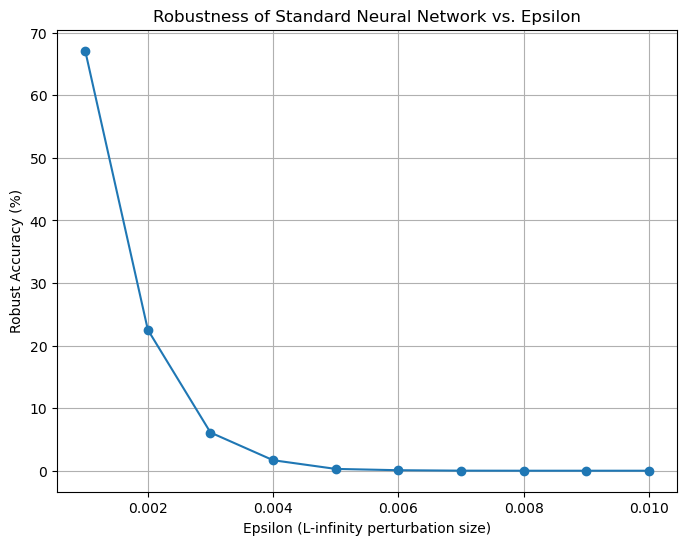

Measuring Robustness for epsilon in [.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]
Epsilon: 0.010 - Robust Accuracy: 74.71%
Epsilon: 0.020 - Robust Accuracy: 71.82%
Epsilon: 0.030 - Robust Accuracy: 69.04%
Epsilon: 0.040 - Robust Accuracy: 65.87%
Epsilon: 0.050 - Robust Accuracy: 62.43%
Epsilon: 0.060 - Robust Accuracy: 59.05%
Epsilon: 0.070 - Robust Accuracy: 55.25%
Epsilon: 0.080 - Robust Accuracy: 49.83%
Epsilon: 0.090 - Robust Accuracy: 43.34%
Epsilon: 0.100 - Robust Accuracy: 35.37%


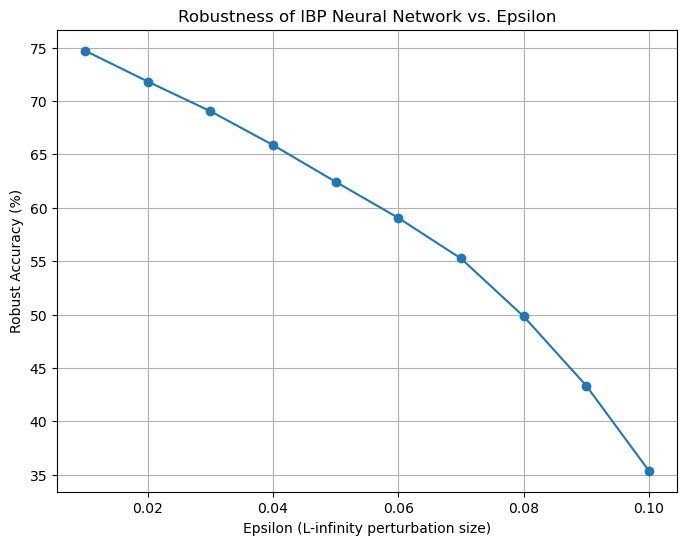

In [ ]:
def graph(model, start, end, title):
    epsilon_values = np.linspace(start, end, 10)

    robust_accuracies = []
    print("Measuring Robustness for epsilon in [.001,.002,.003,.004,.005,.006,.007,.008,.009,.01]")
    for eps in epsilon_values:
        robust_acc = measure_robustness(model, eps)
        robust_accuracies.append(robust_acc)
        print(f"Epsilon: {eps:.3f} - Robust Accuracy: {robust_acc:.2f}%")

    plt.figure(figsize=(8,6))
    plt.plot(epsilon_values, robust_accuracies, marker='o')
    plt.title(title)
    plt.xlabel('Epsilon (L-infinity perturbation size)')
    plt.ylabel('Robust Accuracy (%)')
    plt.grid(True)
    plt.show()
model = torch.load('standardMINST.pth')
graph(model, .001, .01, 'Robustness of Standard Neural Network vs. Epsilon')
model = torch.load('robustMINST.pth')
graph(model, .01, .1, 'Robustness of IBP Neural Network vs. Epsilon')

## Problem 2: IBP for Text

In this problem, you will implement an Interval Bound Propagation (IBP) training procedure for a simple neural network on textual data.

### Network Description

We will perform certified training for the **Bag-of-Words** architecture as described in [JRGL19]. The model is trained on the **IMDB movie review** dataset ([PyTorch Datasets](https://pytorch.org/text/stable/datasets.html)) to predict the sentiment (positive/negative) of each review.

**Model Architecture:**
1. **Embedding Layer:**
   - **Pre-trained Embeddings:** Each word in the input is embedded into a pre-trained embedding space using **GloVe** embeddings ([GloVe Project Page](https://nlp.stanford.edu/projects/glove/)).
   - **Learnable Transformation:** The embeddings are transformed into word vectors using a learnable linear transformation layer followed by a ReLU activation function.
   
2. **Aggregation:**
   - The transformed word vectors are averaged to form a single vector representing the entire input review.
   
3. **Feedforward Network:**
   - **First Layer:** A fully connected layer with a 100-dimensional hidden state followed by a ReLU activation.
   - **Second Layer:** Another fully connected layer with a 100-dimensional hidden state followed by a ReLU activation.
   - **Output Layer:** A final linear layer to obtain the logits.
   
4. **Prediction:**
   - The final logits are passed through a softmax activation function to obtain the prediction probabilities for each sentiment class.
   
**Loss Function:**  
Use **cross-entropy loss** for training the network.

### Task

Implement the **IBP [JRGL19]** training procedure on your network. You can reuse your code from **Problem 1** for the same.

**Requirements:**
- **Standard Accuracy:** Report the accuracy of your network on the standard (unperturbed) test set.
- **Verified Accuracy:** Report the verified accuracy of your network, which indicates the number of test samples for which the network is certified to be robust within a specified perturbation radius.
- **Training Time:** Measure and report the training time of your IBP-trained model.
- **Comparison:** Contrast the training time and performance of the IBP-trained model with that of a standard (non-robust) training procedure.

### Solution Requirements

You should present your solution for this problem in the form of a Jupyter notebook. We recommend using **Google Colab** since it allows for easy interaction with your solution. Alternatively, you can upload the notebook to your **GitHub** repository.

# Explanation of Code

#### **1. Data Preprocessing**
- First, we load the IMDB datasets, splitting into test and train.
- Then, we use a basic tokenizer from torchtext to process the text inputs.


#### **2. Vocabulary Building**
- First, we use the tokenizer to come up with a frequency count of each token in the training data.
- Then, we add special tokens to the vocab in order to account for words that aren't in our tokenizer.
- Next, we create the vocab dictionary that maps words from the tokenized words to indices.
- Then, we load the GloVe embeddings.
- Finally, we create the embedding matrix using GloVe embeddings and random values for words not part of GloVe.

#### **3. Neighborhood Function for Word Embeddings**
- We use scikit-learn's nearest neighbors with cosine similarity to map each word index to a list of neighbor indices which defines the list of allowed substitutions for a word.

#### **4. Interval Bound Propogation**
- We use the same mechanism from the previous question to derive the linear and relu bounds using IBP.
- Then, we use the `worst_case_loss` function to propogate the lower and upper purtubations through the network.
- The worst case loss is computed by calculating the cross-entropy loss for each case and using the `logsumexp` function to approximate the maximum loss over these cases.

#### **5. Precomputing Word Embedding Bounds**
- For each word we compute the lower and upper bounds of each word embedding based on the nearest neighbor calculations from earlier.

#### **6. Model Architecture**
- The model architecture begins with a GloVe embedding layer and a learnable linear layer followed by averaging a ReLU layer.
- Then, there are two more layers consisting of an affine layer followed by ReLU.

#### **7. Training**
- First, we have a collate function that tokenizes, pads sequences to the same length, and converts labels to 0s an 1s.
- Then, we ue the torch dataloader to create iterable batches for training.
- We trained with 10 epochs for both standard and robust training.
- We use the same epsilon and k scheduling from the first question with a k_final value of .4 and eps_max of 1.
- We use 100 hidden layer size and 300 embedding dimension size as from the paper.
- We use the `train_imdb` function to train the standard and robust networks. The function uses k to balance the robust loss with standard loss during robust training.

#### **8. Evaluation**
- We use the `certify_example` function to evaluate if an input is certably robust by checking if the differnce between the lower bound of the true class logit is greater than the upper bound of the other class logit.
- Then, we use the `evaluate_certified_accuracy` function to find the percentage of test examples that the model is certifiably robust for based on the perturbation size epsilon.
- Next, `graph_llm` is used to iterate through 10 equally spaced epsilons and graph the resulted certified robustness.

#### **9. Results**
- The IBP model took about 10 minutes to train on 10 epochs. The standard model took about 2 minutes to train on 10 epochs. The standard model ended with 86% accuracy and the robust model ended with 86% accuracy as well. We plotted certified accuracy for both models and we can see that the certified model did a lot better. The certified model was evaluated against epsilon in the interval [.01, .1] starting with a robust accuracy of about 41% and ended with 2% robust accuracy. The standard model was evaluated against epsilon in the range [.01, .1] starting with a robust accuracy of 43.7% and quickly falling to 0%. The robust model showed better results with greater epsilon values

In [85]:
#llm for probabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset_imdb = IMDB(split='train')
test_dataset_imdb = IMDB(split='test')
tokenizer = get_tokenizer('basic_english')

embedding_dim = 300
glove = GloVe(name='6B', dim=embedding_dim)

token_counts = Counter()
for (label, text) in train_dataset_imdb:
    tokens = tokenizer(text)
    token_counts.update(tokens)

special_tokens = ['<unk>', '<pad>']
for token in special_tokens:
    token_counts[token] = 1e9

dataset_vocab = [word for word, count in token_counts.items()]
vocab = {word: idx for idx, word in enumerate(dataset_vocab)}
vocab_size = len(vocab)

embedding_list = []
for word in vocab:
    if word in glove.stoi:
        idx = glove.stoi[word]
        embedding_list.append(glove.vectors[idx])
    else:
        embedding_list.append(torch.randn(embedding_dim))

embedding_matrix = torch.stack(embedding_list)
embedding_matrix = embedding_matrix.to(device)

In [ ]:
def neighborhood(embedding_matrix, k=8):
    vocab_size = embedding_matrix.size(0)
    N = {}
    embeddings_np = embedding_matrix.cpu().numpy()

    norms = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    normalized_embeddings = embeddings_np / norms
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='cosine').fit(normalized_embeddings)

    distances, indices = nbrs.kneighbors(normalized_embeddings)
    for idx in range(vocab_size):
        neighbor_indices = indices[idx][1:]
        N[idx] = neighbor_indices.tolist()
    return N

In [137]:
def bound_linear(z_lower, z_upper, W, b):
    W_abs = W.abs()
    uk_1 = (z_lower + z_upper)/2
    rk_1 = (z_upper - z_lower)/2
    uk = F.linear(uk_1, W, b)
    rk = F.linear(rk_1, W_abs, None)
    z_lower = uk - rk
    z_upper = uk + rk
    return z_lower, z_upper

def bound_relu(lower_input, upper_input):
    return F.relu(lower_input), F.relu(upper_input)
def precompute_word_embedding_bounds(vocab_size, embedding_matrix, N):
    lower_embedding = torch.zeros_like(embedding_matrix)
    upper_embedding = torch.zeros_like(embedding_matrix)
    for w in range(vocab_size):
        S_w = N.get(w, []) + [w]
        embeddings_S_w = embedding_matrix[S_w]
        lower_embedding[w] = embeddings_S_w.min(dim=0)[0]
        upper_embedding[w] = embeddings_S_w.max(dim=0)[0]
    return lower_embedding, upper_embedding

class BoWModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, glove_embeddings):
        super(BoWModel, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(glove_embeddings, freeze=False)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim, hidden_dim).to(device)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim, num_classes).to(device)
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = torch.mean(x, dim=1)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        return x

def worst_case_loss(model, lower_input, upper_input, labels):
    weight1 = model.linear1.weight
    bias1 = model.linear1.bias
    lower_linear1, upper_linear1 = bound_linear(lower_input, upper_input, weight1, bias1)
    lower_relu1, upper_relu1 = bound_relu(lower_linear1, upper_linear1)

    lower_avg = lower_relu1.mean(dim=1)
    upper_avg = upper_relu1.mean(dim=1)

    weight2 = model.linear2.weight
    bias2 = model.linear2.bias

    lower_linear2, upper_linear2 = bound_linear(lower_avg, upper_avg, weight2, bias2)
    lower_relu2, upper_relu2 = bound_relu(lower_linear2, upper_linear2)

    weight3 = model.linear3.weight
    bias3 = model.linear3.bias

    lower_linear3, upper_linear3 = bound_linear(lower_relu2, upper_relu2, weight3, bias3)
    lower_relu3, upper_relu3 = bound_relu(lower_linear3, upper_linear3)

    weight4 = model.linear4.weight
    bias4 = model.linear4.bias

    lower_logits, upper_logits = bound_linear(lower_relu3, upper_relu3, weight4, bias4)

    batch_size = labels.size(0)
    num_classes = model.linear4.out_features
    worst_case_losses = []
    for i in range(batch_size):
        # Stack the logits from the corners
        logits_corners = torch.stack([
            torch.stack([lower_logits[i, 0], lower_logits[i, 1]]),
            torch.stack([lower_logits[i, 0], upper_logits[i, 1]]),
            torch.stack([upper_logits[i, 0], lower_logits[i, 1]]),
            torch.stack([upper_logits[i, 0], upper_logits[i, 1]]),
        ], dim=0)  # Shape: (4, num_classes)

        # Compute cross-entropy losses for all corners
        labels_i = labels[i].expand(4)  # Shape: (4,)
        losses = F.cross_entropy(logits_corners, labels_i, reduction='none')  # Shape: (4,)

        # Use logsumexp to approximate the maximum loss
        worst_case_loss = torch.logsumexp(losses, dim=0)
        worst_case_losses.append(worst_case_loss)
    worst_case_losses = torch.stack(worst_case_losses)

    return worst_case_losses.mean()

In [86]:
N = neighborhood(embedding_matrix, k=8)
lower_embedding, upper_embedding = precompute_word_embedding_bounds(len(vocab), embedding_matrix, N)
lower_embedding = lower_embedding.to(device)
upper_embedding = upper_embedding.to(device)

In [96]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (label, text) in batch:
        label_list.append(1 if label == 2 else 0)
        tokens = tokenizer(text)
        indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
        processed_text = torch.tensor(indices, dtype=torch.long)
        text_list.append(processed_text)
        lengths.append(len(processed_text))
    text_list = nn.utils.rnn.pad_sequence(text_list, padding_value=vocab['<pad>'])
    return torch.tensor(label_list, dtype=torch.long), text_list.t(), torch.tensor(lengths, dtype=torch.long)
batch_size = 64
train_loader_imdb = DataLoader(train_dataset_imdb, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader_imdb = DataLoader(test_dataset_imdb, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [189]:
epochs = 10
T_init = 5
k_max = .4
eps_max = 1
embedding_dim = 300
num_classes = 2
hidden_dim = 100
learning_rate = 0.001
total_samples = len(list(IMDB(split='train')))
total_steps = total_samples // batch_size * epochs

In [194]:
# Training
def train_imdb(model, robust):
  model.train()
  optimizer_BoW = optim.Adam(model.parameters(), lr=learning_rate)

  global_step = 0
  for epoch in range(epochs):
      total_loss = 0.0
      total_correct = 0
      total_samples = 0
      k = getK(global_step, total_steps, k_max)
      epsilon = getEps(global_step, total_steps, eps_max)

      for labels, x_batch, lengths in train_loader_imdb:
          labels = labels.to(device)
          x_batch = x_batch.to(device)
          optimizer_BoW.zero_grad()

          outputs = model(x_batch)
          loss = F.cross_entropy(outputs, labels)
          if robust:
            lower_input = lower_embedding[x_batch]
            upper_input = upper_embedding[x_batch]

            embedding_input = model.embedding_layer(x_batch)
            lower_input = embedding_input - epsilon * (embedding_input - lower_input)
            upper_input = embedding_input + epsilon * (upper_input - embedding_input)

            worst_loss = worst_case_loss(model, lower_input, upper_input, labels)

            loss = (1 - k) * loss + k * worst_loss
          loss.backward()
          optimizer_BoW.step()

          total_loss += loss.item() * labels.size(0)
          total_correct += (outputs.argmax(dim=1) == labels).sum().item()
          total_samples += labels.size(0)
          global_step += 1

      avg_loss = total_loss / total_samples
      accuracy = total_correct / total_samples
      print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
def evaluate_imdb(model):
  total_correct = 0
  total_samples = 0
  model.eval()
  with torch.no_grad():
      for labels, x_batch, lengths in test_loader_imdb:
          labels = labels.to(device)
          x_batch = x_batch.to(device)
          outputs = model(x_batch)
          total_correct += (outputs.argmax(dim=1) == labels).sum().item()
          total_samples += labels.size(0)

  test_accuracy = total_correct / total_samples
  print(f'Test Accuracy: {test_accuracy:.4f}')

### Training BoW IBP Network

In [195]:
BoW = BoWModel(embedding_dim, hidden_dim, num_classes, embedding_matrix).to(device)
train_imdb(BoW, True)
torch.save(BoW.state_dict(), 'BoW.pth')
evaluate_imdb(BoW)

Epoch 1, Loss: 0.1181, Accuracy: 0.9589
Epoch 2, Loss: 4.9897, Accuracy: 0.6108
Epoch 3, Loss: 0.9078, Accuracy: 0.6348
Epoch 4, Loss: 0.6936, Accuracy: 0.5525
Epoch 5, Loss: 0.6889, Accuracy: 0.6021
Epoch 6, Loss: 0.6852, Accuracy: 0.6634
Epoch 7, Loss: 0.6830, Accuracy: 0.7469
Epoch 8, Loss: 0.6795, Accuracy: 0.8184
Epoch 9, Loss: 0.6782, Accuracy: 0.8650
Epoch 10, Loss: 0.6763, Accuracy: 0.8609
Test Accuracy: 0.8637


### Training Standard BoW Network

In [192]:
BoW_standard = BoWModel(embedding_dim, hidden_dim, num_classes, embedding_matrix).to(device)
epochs = 10
train_imdb(BoW_standard, False)
torch.save(BoW_standard.state_dict(), 'BoW_standard.pth')
evaluate_imdb(BoW_standard)

Epoch 1, Loss: 0.1240, Accuracy: 0.9602
Epoch 2, Loss: 0.0061, Accuracy: 0.9987
Epoch 3, Loss: 0.0021, Accuracy: 0.9995
Epoch 4, Loss: 0.0016, Accuracy: 0.9998
Epoch 5, Loss: 0.0016, Accuracy: 0.9999
Epoch 6, Loss: 0.0015, Accuracy: 0.9998
Epoch 7, Loss: 0.0015, Accuracy: 0.9997
Epoch 8, Loss: 0.0016, Accuracy: 0.9997
Epoch 9, Loss: 0.0014, Accuracy: 0.9998
Epoch 10, Loss: 0.0014, Accuracy: 0.9998
Test Accuracy: 0.8625


### Testing Networks for Robustness

In [160]:
def certify_example(model, lower_input, upper_input, true_label):
    weight1 = model.linear1.weight
    bias1 = model.linear1.bias

    lower_linear1, upper_linear1 = bound_linear(lower_input, upper_input, weight1, bias1)
    lower_relu1, upper_relu1 = bound_relu(lower_linear1, upper_linear1)

    lower_avg = lower_relu1.mean(dim=0)
    upper_avg = upper_relu1.mean(dim=0)

    weight2 = model.linear2.weight
    bias2 = model.linear2.bias

    lower_linear2, upper_linear2 = bound_linear(lower_avg.unsqueeze(0), upper_avg.unsqueeze(0), weight2, bias2)
    lower_relu2, upper_relu2 = bound_relu(lower_linear2, upper_linear2)

    weight3 = model.linear3.weight
    bias3 = model.linear3.bias

    lower_linear3, upper_linear3 = bound_linear(lower_relu2, upper_relu2, weight3, bias3)
    lower_relu3, upper_relu3 = bound_relu(lower_linear3, upper_linear3)

    weight4 = model.linear4.weight
    bias4 = model.linear4.bias

    lower_logits, upper_logits = bound_linear(lower_relu3, upper_relu3, weight4, bias4)

    true_class = true_label.item()
    other_class = 1 - true_class

    diff_lower = lower_logits[0, true_class] - upper_logits[0, other_class]

    if diff_lower > 0:
        return True
    else:
        return False

def evaluate_certified_accuracy(model, test_loader, epsilon):
    model.eval()
    certified_correct = 0
    total_samples = 0

    with torch.no_grad():
        for labels, x_batch, lengths in test_loader:
            labels = labels.to(device)
            x_batch = x_batch.to(device)
            batch_size = labels.size(0)

            embedding_input = model.embedding_layer(x_batch)
            perturbation = epsilon * (upper_embedding[x_batch] - lower_embedding[x_batch]) / 2
            center = (upper_embedding[x_batch] + lower_embedding[x_batch]) / 2

            lower_input = center - perturbation
            upper_input = center + perturbation

            for i in range(batch_size):
                is_certified = certify_example(model, lower_input[i], upper_input[i], labels[i])
                if is_certified:
                    certified_correct += 1
                total_samples += 1
    certified_accuracy = certified_correct / total_samples
    return certified_accuracy * 100


def graph_llm(model, start, end, title):
    epsilon_values = np.linspace(start, end, 10)
    robust_accuracies = []
    for eps in epsilon_values:
        robust_acc = evaluate_certified_accuracy(model, test_loader_imdb, eps)
        robust_accuracies.append(robust_acc)
        print(f"Epsilon: {eps}, Robust Accuracy: {robust_acc}%")
    plt.figure(figsize=(8,6))
    plt.plot(epsilon_values, robust_accuracies, marker='o')
    plt.title(title)
    plt.xlabel('Epsilon (L-infinity perturbation size)')
    plt.ylabel('Robust Accuracy (%)')
    plt.grid(True)
    plt.show()

Epsilon: 0.01, Robust Accuracy: 40.967999999999996%
Epsilon: 0.020000000000000004, Robust Accuracy: 27.752%
Epsilon: 0.030000000000000006, Robust Accuracy: 19.752%
Epsilon: 0.04000000000000001, Robust Accuracy: 13.752%
Epsilon: 0.05000000000000001, Robust Accuracy: 9.484%
Epsilon: 0.06000000000000001, Robust Accuracy: 6.644%
Epsilon: 0.07, Robust Accuracy: 4.732%
Epsilon: 0.08, Robust Accuracy: 3.58%
Epsilon: 0.09000000000000001, Robust Accuracy: 2.692%
Epsilon: 0.1, Robust Accuracy: 1.992%


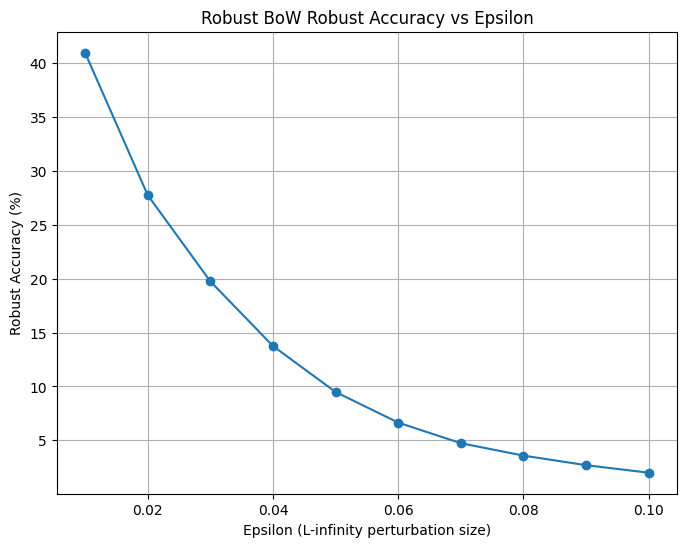

In [196]:

graph_llm(BoW, .01,.10, "Robust BoW Robust Accuracy vs Epsilon")

Epsilon: 0.01, Robust Accuracy: 43.763999999999996%
Epsilon: 0.020000000000000004, Robust Accuracy: 0.012%
Epsilon: 0.030000000000000006, Robust Accuracy: 0.0%
Epsilon: 0.04000000000000001, Robust Accuracy: 0.0%
Epsilon: 0.05000000000000001, Robust Accuracy: 0.0%
Epsilon: 0.06000000000000001, Robust Accuracy: 0.0%
Epsilon: 0.07, Robust Accuracy: 0.0%
Epsilon: 0.08, Robust Accuracy: 0.0%
Epsilon: 0.09000000000000001, Robust Accuracy: 0.0%
Epsilon: 0.1, Robust Accuracy: 0.0%


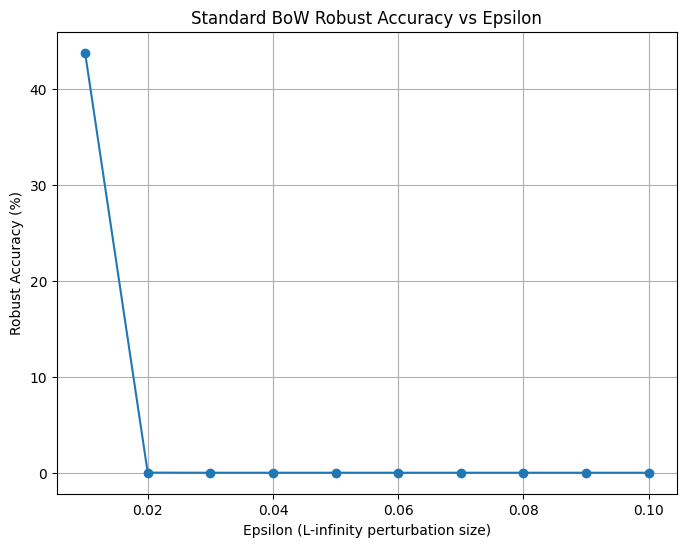

In [177]:
graph_llm(BoW_standard, 0.01, .1, "Standard BoW Robust Accuracy vs Epsilon")

In [ ]:
#interacting with network
sample_input = "it started off great but i hate this movie so much. its so horrible"
# use collate batch
sample_input = collate_batch([(1, sample_input)])[1].to(device)
BoW.eval()
with torch.no_grad():
    output = BoW(sample_input)
    print(output)
    print(output.argmax(dim=1))


## Problem 3: $L_∞$ Networks (Lp Nets)

We discussed **$L_∞$** networks in class, as described in [ZCL+21]. In this problem, you are tasked with formally deriving a general expression or a precise lower bound for the **$L_∞$ certified radius** of an **$L_∞$ network** for any given input **x** and weight **w**, using the properties of the network.

### Setup

An $L_\infty$ network is constructed using $L_\infty$-dist neurons, where each neuron computes the operation:

$$
    u(\mathbf{x}, \theta) = \|\mathbf{x} - \mathbf{w}\|_\infty + b,
$$

with parameters $\theta = \{ \mathbf{w}, b \}$. The network output is defined as:

$$
    g(\mathbf{x}) = ( -x_1^{(L)}, -x_2^{(L)}, \ldots, -x_M^{(L)} ),
$$

where $x_i^{(L)}$ is the output of the last layer for class $i$, and $M$ is the number of classes. The classifier is then:

$$
    f(\mathbf{x}) = \arg \max_{i \in [M]} g_i(\mathbf{x}).
$$

$L_\infty$ networks are 1-Lipschitz with respect to the $L_\infty$ norm:

$$
    \|g(\mathbf{x_1}) - g(\mathbf{x_2})\|_\infty \leq \|\mathbf{x_1} - \mathbf{x_2}\|_\infty, \quad \forall \mathbf{x_1}, \mathbf{x_2} \in \mathbb{R}^d.
$$

### Certified Radius Derivation

We want a general expression or a precise lower bound for the certified radius $R_{\text{cert}}$ of the $L_\infty$ network, given an input $\mathbf{x}$ and weights $\mathbf{w}$. The certified radius is the minimum perturbation required to change the classifier's prediction:

$$
    R_{\text{cert}}(f; \mathbf{x}, y) = \inf_{\mathbf{x'} : f(\mathbf{x'}) \neq f(\mathbf{x})} \|\mathbf{x'} - \mathbf{x}\|_\infty,
$$


### Step 1: Define the Margin

Let's define the margin at input $\mathbf{x}$ as the difference between the logit for the true class and the largest logit for any other class:

$$
    \text{margin}(\mathbf{x}; g) = g_y(\mathbf{x}) - \max_{i \neq y} g_i(\mathbf{x}).
$$

### Step 2: Utilize the Lipschitz Property

Since the network $g$ is 1-Lipschitz with respect to the $L_\infty$ norm, any perturbation $\delta$ satisfies:

$$
    \|g(\mathbf{x} + \delta) - g(\mathbf{x})\|_\infty \leq \|\delta\|_\infty.
$$

Meaning that each component of the output can change by at most $\|\delta\|_\infty$:

$$
    |g_i(\mathbf{x} + \delta) - g_i(\mathbf{x})| \leq \|\delta\|_\infty, \quad \forall i \in [M].
$$

### Step 3: Find the Minimum Perturbation to Change the Prediction

To change the prediction from class $y$ to another class $k \neq y$, the following condition must be met:

$$
    g_y(\mathbf{x} + \delta) \leq g_k(\mathbf{x} + \delta).
$$

Using the Lipschitz property, we get:

$$
    g_y(\mathbf{x} + \delta) \geq g_y(\mathbf{x}) - \|\delta\|_\infty,
$$

$$
    g_k(\mathbf{x} + \delta) \leq g_k(\mathbf{x}) + \|\delta\|_\infty.
$$

Therefore, for the prediction to change, it suffices that:

$$
    g_y(\mathbf{x}) - \|\delta\|_\infty \leq g_k(\mathbf{x}) + \|\delta\|_\infty.
$$

Simplifying, we get:

$$
    g_y(\mathbf{x}) - g_k(\mathbf{x}) \leq 2 \|\delta\|_\infty.
$$

### Step 4: Derive the Certified Radius

The minimum $\|\delta\|_\infty$ required to change the prediction to any other class is therefore at least half the margin:

$$
    \|\delta\|_\infty \geq \frac{1}{2} \left( g_y(\mathbf{x}) - \max_{i \neq y} g_i(\mathbf{x}) \right).
$$

Thus, the certified radius is given by:

$$
    R_{\text{cert}}(f; \mathbf{x}, y) \geq \frac{\text{margin}(\mathbf{x}; g)}{2}.
$$